In this project, we will:
 - use simulated daily and intraday 5-min data
 - load daily and 5-minute data
 - define function to fit GARCH model on the daily data and predict 1-day ahead volatility in a rolling window
 - calculate prediction premium and forma  daily signal from it
 - merge with intraday data and calculate intraday indicators to form the intraday signal 
 - generate the position entry and hold until end of the day
 - calculate final strategy returns 

In [75]:
import matplotlib.pyplot as plt
from arch import arch_model
import pandas as pd
import numpy as np
import warnings
import pandas_ta

warnings.filterwarnings('ignore')

plt.style.use("ggplot")

ImportError: cannot import name 'NaN' from 'numpy' (/Users/asirgue/Dev24/intraday_strategy_GARCH_model/venv/lib/python3.11/site-packages/numpy/__init__.py)

### 1. Load simulated daily and simulated 5-minute data

In [53]:
daily_df = pd.read_csv("./simulated_daily_data.csv")
daily_df["Date"] = pd.to_datetime(daily_df['Date'])
daily_df = daily_df.set_index('Date')

daily_df['log_return'] = np.log(daily_df['Adj Close']).diff()

intraday_5m_df = pd.read_csv("./simulated_5min_data.csv")
intraday_5m_df['datetime'] = pd.to_datetime(intraday_5m_df['datetime'])
intraday_5m_df['date'] = pd.to_datetime(intraday_5m_df['datetime']).dt.strftime("%Y-%m-%m")

intraday_5m_df = intraday_5m_df.set_index('datetime')



### 2. Define function to fit GARCH model and predict 1-day ahead volatility in a rolling window

We use parameters minimising the Bayesian information criteria (autoregressive order=1 and movign average order =3).

In [54]:
daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()

daily_df['variance'] = daily_df['log_ret'].rolling(180).var()

def predict_volatility(x):
    
    best_model = arch_model(y=x,
                            p=1,
                            q=3).fit(update_freq=5,
                                     disp='off')
    
    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1,0]
    
    return variance_forecast

daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x))

daily_df
    

/Users/asirgue/Dev24/intraday_strategy_GARCH_model/venv/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/asirgue/Dev24/intraday_strategy_GARCH_model/venv/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/asirgue/Dev24/intraday_strategy_GARCH_model/venv/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/asirgue/Dev24/intraday_strategy_GARCH_model/venv/lib/python3.11/site-packages/arch/univariate/base.py:766: Conv

,Open,High,Low,Close,Adj Close,Volume,Unnamed: 7,log_return,log_ret,variance,predictions
Date,,,,,,,,,,,
2014-09-17,116.466003,117.043503,113.105499,114.333504,114.333504,2.105680e+07,NaN,NaN,NaN,NaN,NaN
2014-09-18,114.214996,114.214996,103.276001,106.110001,106.110001,3.448320e+07,NaN,-0.074643,-0.074643,NaN,NaN
2014-09-19,106.025749,106.958748,96.133003,98.698998,98.698998,3.791970e+07,NaN,-0.072402,-0.072402,NaN,NaN
2014-09-20,98.668251,105.823998,97.470749,102.225998,102.225998,3.686360e+07,NaN,0.035111,0.035111,NaN,NaN
2014-09-21,102.021248,103.106499,98.295250,99.705254,99.705254,2.658010e+07,NaN,-0.024968,-0.024968,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2023-09-14,6557.069336,6693.655762,6542.862793,6634.918457,6634.918457,1.381136e+10,NaN,0.011801,0.011801,0.000393,0.000334
2023-09-15,6633.454590,6710.124512,6560.175293,6652.173340,6652.173340,1.147974e+10,NaN,0.002597,0.002597,0.000385,0.000292
2023-09-16,6651.549805,6688.692383,6618.472656,6642.070313,6642.070313,7.402031e+09,NaN,-0.001520,-0.001520,0.000384,0.000286


### 3. Calculate prediction premimum and form a daily signal from it

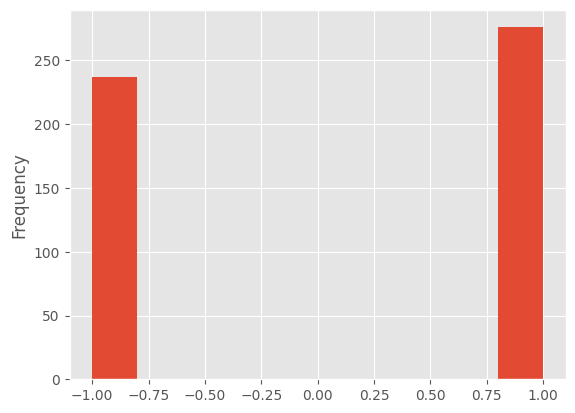

In [58]:
daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']

daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()

daily_df['signal_daily'] = daily_df.apply(lambda x: 1 if (x['prediction_premium']>x['premium_std'])
                                         else (-1 if (x['prediction_premium']<x['premium_std']*-1) else np.nan),
                                         axis=1)

daily_df['signal_daily'] = daily_df['signal_daily'].shift()

daily_df

daily_df["signal_daily"].plot(kind="hist")
plt.show()

In [56]:
final_df = intraday_5m_df.reset_index()\
                            .merge(daily_df[['signal_daily']].reset_index(),
                                   left_on='date',
                                   right_on='Date')\
                            .drop(['date','Date'], axis=1)\
                            .set_index('datetime')

final_df['rsi'] = pandas_ta.rsi(close=final_df['close'],
                                length=20)

final_df['lband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,0]

final_df['uband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,2]

final_df['signal_intraday'] = final_df.apply(lambda x: 1 if (x['rsi']>70)&
                                                            (x['close']>x['uband'])
                                             else (-1 if (x['rsi']<30)&
                                                         (x['close']<x['lband']) else np.nan),
                                             axis=1)

final_df['return'] = np.log(final_df['close']).diff()

final_df

KeyError: "None of [Index(['signal_daily'], dtype='object')] are in the [columns]"

### 5. Generate the position and then hold until end of day

In [ ]:
final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['signal_daily']==1)&(x['signal_intraday']==1)
                                        else (1 if (x['signal_daily']==-1)&(x['signal_intraday']==-1) else np.nan),
                                        axis=1)

final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign']\
                                  .transform(lambda x: x.ffill())

final_df['forward_return'] = final_df['return'].shift(-1)

final_df['strategy_return'] = final_df['forward_return']*final_df['return_sign']

daily_return_df = final_df.groupby(pd.Grouper(freq='D'))['strategy_return'].sum()

### 6. Calculate strategy returns

In [ ]:
import matplotlib.ticker as mtick

strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)

strategy_cumulative_return.plot(figsize=(16,6))

plt.title('Intraday Strategy Returns')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()